# 2022 Qatar World Cup Analysis

The World Cup is one of the, if not the largest, sporting event in the world. The World Cup is a tournament consisting of some of the best qualifying nations in international football. Countries are divided into groups, where the top two teams from each group move on to the ‘knockout rounds’, effectively dwindling down the competition until one team is left standing.The World Cup is a global event that transcends borders, cultures, and languages, captivating audiences with the sheer talent, passion, and dedication of the world's top footballers. The World Cup also serves as a platform for countries to showcase their national identity and pride, and to unite their citizens around a common goal. Whether you are a casual fan or a die-hard supporter, the World Cup is an unforgettable experience that captures the imagination and inspires a sense of unity that extends far beyond the pitch. And for the players, it is considered the highest honor in the sport; one that demands a lot of passion and excellence in order to persevere and bring home glory to their country.

The 2022 World Cup in Qatar has recently concluded with an Argentinian extra-time victory in the final over France; a dramatic victory that perfectly captures the essence of the tournament. The dataset that we will be utilizing in our project focuses on each individual match from the tournament, and contains a large amount of data about the match itself, specifically for each team; possession, shots attempted, shots on goal, total passes, etc. We are hoping to showcase some trends, and insights that can summarize and visualize the tournament effectively through data.

Our goal is to provide some background on the tournament; the teams, the players, the matches, and the results. We will be using the dataset to answer some questions that we have about the tournament, and to provide some insights that can help us understand the tournament better.

Outside our background analysis, some questions we hope to answer are:

- X Which matches were the most attended? We are interested to see if there are trends between attendance and the teams playing, or the stage of the tournament.

- X Who was the most efficient player throughout the tournament, in regard to the attack? (we can calculate some statistics for this, such as G/A, etc.)

- X Does the difference in rounds have an effect on the way that teams play? (this can be measured by shots attempted, possession, etc.)

- X Having possession is an emphasis in modern football, but does having more possession actually lead to more success?

- How do different formations relate to style of play? We want to see if certain formations show a coorelation with certain styles of play, such as possession, and also see which formations were the most popular in the tournament/led to the most success.

## Importing packages

In [17]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotnine import *

## Loading, cleaning, and exploring datasets

We have multiple main datasets which we will be working with in our project; our main dataset is the `matches` dataset which contains information about the matches played in the 2022 Qatar World Cup. The second dataset, `countries`, relates to the individual country statistics, which we will be aggregating from our information about each match in order to get a better understanding of the teams and their performance. Lastly, we are going to take a look at a `players` dataset, which contains much information about the actual participants in the tournament, and their performance in the matches.

### Matches Dataset - loading and cleaning

In [18]:
matches = pd.read_csv('data/cup.csv')
matches[['team1', 'team2']].head()

,team1,team2
0,QATAR,ECUADOR
1,ENGLAND,IRAN
2,SENEGAL,NETHERLANDS
3,UNITED STATES,WALES
4,ARGENTINA,SAUDI ARABIA


In [19]:
matches = matches[[
    'team1',
    'team2',
    'possession team1',
    'possession team2',
    'possession in contest',
    'number of goals team1',
    'number of goals team2',
    'category',
    'total attempts team1',
    'total attempts team2',
    'conceded team1',
    'conceded team2',
    'assists team1',
    'assists team2',
    'yellow cards team1',
    'yellow cards team2',
    'red cards team1',
    'red cards team2',
    'fouls against team1',
    'fouls against team2',
    'passes team1',
    'passes team2',
    'passes completed team1',
    'passes completed team2',
    'goal preventions team1',
    'goal preventions team2',
    'forced turnovers team1',
    'forced turnovers team2'
]]

matches['team1'] = matches['team1'].str.title()
matches['team2'] = matches['team2'].str.title()

matches['GroupID'] = matches['category'].apply(lambda x: x[-1] if 'Group' in x else np.nan)
matches['category'] = matches['category'].apply(lambda x: x[:-2] if 'Group' in x else x)

matches['possession team1'] = matches['possession team1'].str[:-1].astype(int)
matches['possession team2'] = matches['possession team2'].str[:-1].astype(int)
matches['possession in contest'] = matches['possession in contest'].str[:-1].astype(int)

matches2 = pd.read_csv('data/match_data.csv')[['home_team', 'away_team', 'attendance', 'venue', 'home_formation', 'away_formation']]
matches2 = matches2.rename(columns={'home_team': 'team1', 'away_team': 'team2', 'home_formation': 'formation team1', 'away_formation': 'formation team2'})
matches2['team1'] = matches2['team1'].replace('IR Iran', 'Iran')
matches2['team2'] = matches2['team2'].replace('IR Iran', 'Iran')

matches = matches.merge(matches2, on=['team1', 'team2'], how='left')

In [20]:
matches['category'].unique()

array(['Group', 'Round of 16', 'Quarter-final', 'Semi-final',
       'Play-off for third place', 'Final'], dtype=object)

In [21]:
# dividing the data based on what stage of the tournament the match was in (just in case we want to look at the data in this way later)
groupMatches = matches.loc[matches['category'] == 'Group']
ro16 = matches.loc[matches['category'] == 'Round of 16']
quarterfinals = matches.loc[matches['category'] == 'Quarter-final']
semifinals = matches.loc[matches['category'] == 'Semi-final']
thirdPlaceMatch = matches.loc[matches['category'] == 'Play-off for third place']
final = matches.loc[matches['category'] == 'Final']

### Countries Dataset - loading and cleaning

In [22]:
countries = pd.read_csv('data/precup_rank.csv', index_col='Nation')
countries.head()

,Rank,Points,World Cup Wins
Nation,,,
Brazil,1,1841.30,5
Belgium,2,1816.71,0
Argentina,3,1773.88,3
France,4,1759.78,2
England,5,1728.47,1


In [23]:
stats = ['Possession', 'Total Passes', 'Completed Passes', 'Shot Attempts', 'Total Goals', 'Conceded', 'Assists', 'Fouls',
          'Yellow Cards', 'Red Cards', 'Saves',
          'Forced Turnovers']
category = [' in Group', ' in Round of 16', ' in Quarter-final', ' in Semi-final', 
          ' in Play-off for third place', ' in Final']

for stat in stats:
  for group in category:
    countries[stat + group] = 0

countries['GroupID'] = ''

Now that we have our `countries` dataset prepared for data to enter it, we need to start to modify our `matches` dataset, so that any redundant information is discarded, and all the information we need is correctly represented.

We are now going to write some code which will allow us to clean up the way some of this data looks. Ideally, we want to observe these statistics based on country, while we have it here as `team1` or `team2`, which isn't really helpful if we want to get a context of a particular country. So, using the `countries` dataset that we have introduced earlier that just contains their FIFA rank at the time of the World Cup, we will be adding each countries individual statistics to the dataset.

In [24]:
tempDict = {'Possession in ': 'possession team', 'Total Passes in ': 'passes team', 'Completed Passes in ': 'passes completed team', 
                        'Total Goals in ': 'number of goals team',
                        'Conceded in ': 'conceded team', 'Assists in ': 'assists team',
                        'Forced Turnovers in ': 'forced turnovers team', 'Saves in ': 'goal preventions team',
                        'Fouls in ': 'fouls against team', 'Yellow Cards in ': 'yellow cards team',
                        'Red Cards in ': 'red cards team', 'Shot Attempts in ': 'total attempts team'}
def parseRound(round):
    teamID = ''
    for team in countries.index:
        roundMatches = round.loc[((round['team1'] == team) | (round['team2'] == team))]
        for _, match in roundMatches.iterrows():
            teamID = '1' if match['team1'] == team else '2'          
            if match['category'] == 'Group':
                countries.loc[team, f'GroupID'] = match[f'GroupID']
            for key, val in tempDict.items():
              left = key+match["category"]
              right = match[val + teamID]
              countries.loc[team, left] += right
            

toParse = [groupMatches, ro16, quarterfinals, semifinals, thirdPlaceMatch, final]
for tp in toParse:
  parseRound(tp)

In [25]:
countries['Wins'] = 0
countries['Draws'] = 0
countries['Losses'] = 0
def calculateRecord():
    for team in countries.index:
        for _, match in matches.iterrows():
            if (match['team1'] == team) or (match['team2'] == team):
                if match['number of goals team1'] != match['number of goals team2']:
                    if ((match['team1'] == team) and (match['number of goals team1'] > match['number of goals team2'])) or ((match['team2'] == team) and (match['number of goals team2'] > match['number of goals team1'])) :
                        countries.loc[team, 'Wins'] += 1
                    else:
                        countries.loc[team, 'Losses'] += 1
                else:
                    countries.loc[team, 'Draws'] += 1

calculateRecord()

In [26]:
countries['Average Possession in Group'] = round(countries['Possession in Group'] / 3, 2)
countries['Goals Per Game in Group'] = round(countries['Total Goals in Group'] / 3, 2)

countries['Total Goals'] = countries['Total Goals in Group'] + countries['Total Goals in Round of 16'] + \
    countries['Total Goals in Quarter-final'] + countries['Total Goals in Semi-final'] + countries['Total Goals in Play-off for third place'] \
        + countries['Total Goals in Final']

In [27]:
groupA = countries.loc[countries['GroupID'] == 'A']
groupB = countries.loc[countries['GroupID'] == 'B']
groupC = countries.loc[countries['GroupID'] == 'C']
groupD = countries.loc[countries['GroupID'] == 'D']
groupE = countries.loc[countries['GroupID'] == 'E']
groupF = countries.loc[countries['GroupID'] == 'F']
groupG = countries.loc[countries['GroupID'] == 'G']
groupH = countries.loc[countries['GroupID'] == 'H']

print(f'Group A average team ranking: {groupA["Rank"].mean()}')
print(f'Group B average team ranking: {groupB["Rank"].mean()}')
print(f'Group C average team ranking: {groupC["Rank"].mean()}')
print(f'Group D average team ranking: {groupD["Rank"].mean()}')
print(f'Group E average team ranking: {groupE["Rank"].mean()}')
print(f'Group F average team ranking: {groupF["Rank"].mean()}')
print(f'Group G average team ranking: {groupG["Rank"].mean()}')
print(f'Group H average team ranking: {groupH["Rank"].mean()}')

Group A average team ranking: 30.0
Group B average team ranking: 15.0
Group C average team ranking: 23.25
Group D average team ranking: 20.5
Group E average team ranking: 18.25
Group F average team ranking: 19.25
Group G average team ranking: 20.0
Group H average team ranking: 28.0


It seems that based on the mean ranks of our groups, Group B has the highest average rank, which coins this group 'The Group of Death', a term designated to the toughest group in the tournament. On the other hand, Group A seems to have the lowest average rank. Let's take a look at the two groups, and see what that's about.

In [28]:
groupB[['Rank']]

,Rank
Nation,
England,5
United States,16
Wales,19
Iran,20


Looking at the group of death, we can see that all 4 teams are ranked in the top 20, with 3 of the teams being very close to each other in rank.

In [29]:
groupA[['Rank']]

,Rank
Nation,
Netherlands,8
Senegal,18
Ecuador,44
Qatar,50


This group is much different than Group B; while we can see that we have 2 top 20 nations here, but two of the lower ranked countries in the tournaments as well, in Ecuador and Qatar (the host country)

### Players Dataset - loading and cleaning

In [30]:
players = pd.read_csv('data/player_stats.csv')

duplicate_columns = ['player', 'club', 'position', 'age', 'team', 'birth_year', 'minutes_90s']
players = players[duplicate_columns]

keeper_columns = ['position','team','age','club','birth_year','games','games_starts','minutes','minutes_90s']

player_defense = pd.read_csv('data/player_defense.csv').drop(duplicate_columns[2:], axis=1)
player_shooting = pd.read_csv('data/player_shooting.csv').drop(duplicate_columns[2:], axis=1)
player_stats = pd.read_csv('data/player_stats.csv')[['player','xg_per90','xg_assist_per90','xg_xg_assist_per90','npxg_per90','npxg_xg_assist_per90','goals_per90','assists_per90','goals_assists_per90']]
player_possession = pd.read_csv('data/player_possession.csv').drop(duplicate_columns[2:], axis=1)
player_keepers = pd.read_csv('data/player_keepers.csv').drop(keeper_columns, axis=1)
player_passing = pd.read_csv('data/player_passing.csv').drop(duplicate_columns[2:], axis=1)
player_playingtime = pd.read_csv('data/player_playingtime.csv')[['player', 'minutes','minutes_per_game']]
player_gca = pd.read_csv('data/player_gca.csv')[['player', 'sca','sca_per90','gca','gca_per90']]

player_keepers = pd.merge(players.loc[players['position'] == 'GK'], player_keepers, on='player', how='left')


# merging all of the above dataframes into one
players = players.merge(player_defense, on='player')
players = players.merge(player_shooting, on='player')
players = players.merge(player_possession, on='player')
players = players.merge(player_passing, on='player')
players = players.merge(player_stats, on='player')
players = players.merge(player_playingtime, on='player')
players = players.merge(player_gca, on='player')

players['age'] = players['age'].astype(str).str[:2].astype(int)
players['G/A'] = players['goals'] + players['assists']

players[['player', 'team']].head()

,player,team
0,Aaron Mooy,Australia
1,Aaron Ramsey,Wales
2,Abdelhamid Sabiri,Morocco
3,Abdelkarim Hassan,Qatar
4,Abderrazak Hamdallah,Morocco


## Background analysis: Visualizing the countries

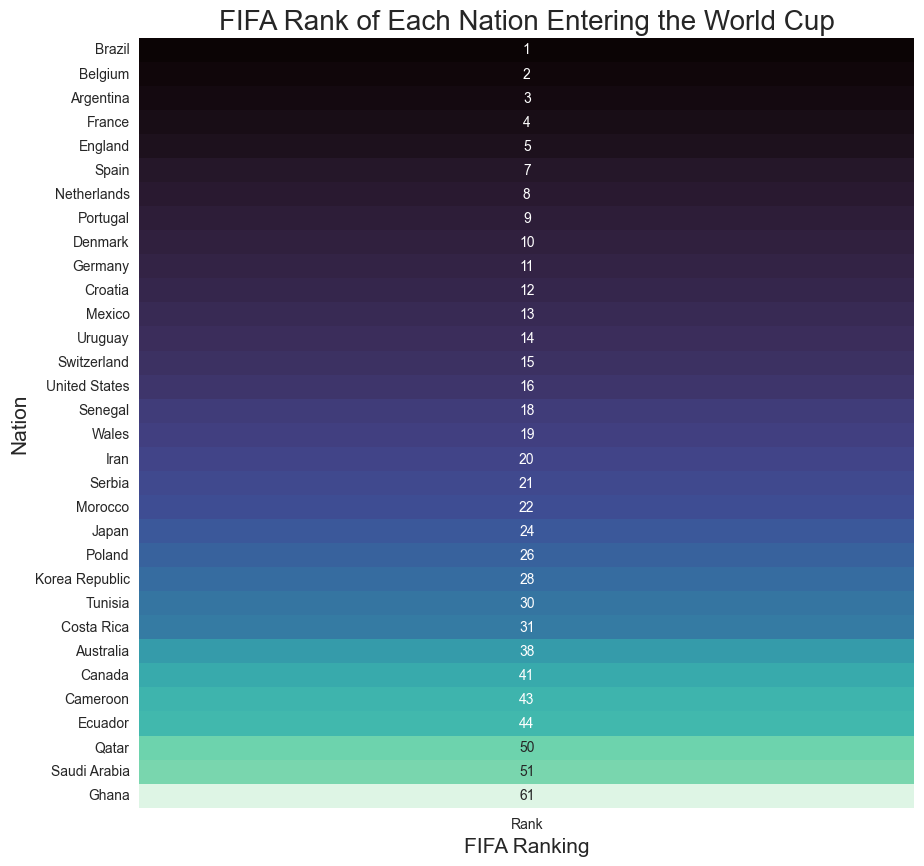

In [31]:
plt.figure(figsize=(10, 10))
sns.set_style('darkgrid')

sns.heatmap(countries['Rank'].to_frame(), annot=True, fmt='g', cmap='mako', cbar=False)
plt.title('FIFA Rank of Each Nation Entering the World Cup', fontsize=20)
plt.xlabel('FIFA Ranking', fontsize=15)
plt.ylabel('Nation', fontsize=15)
plt.show()

This is interesting to visualize because one might assume that a tournament consisting of the best 32 national teams in the world, would have the top 32 ranked countries participating in the tournament. However, this is not the case, as qualification to the World Cup is a long and difficult process, and many of the top ranked countries in the world are not able to qualify for the tournament. This is why we have countries like Saudi Arabia and Ghana, who are ranked 51st and 61st in the world respectively, participating in the tournament.

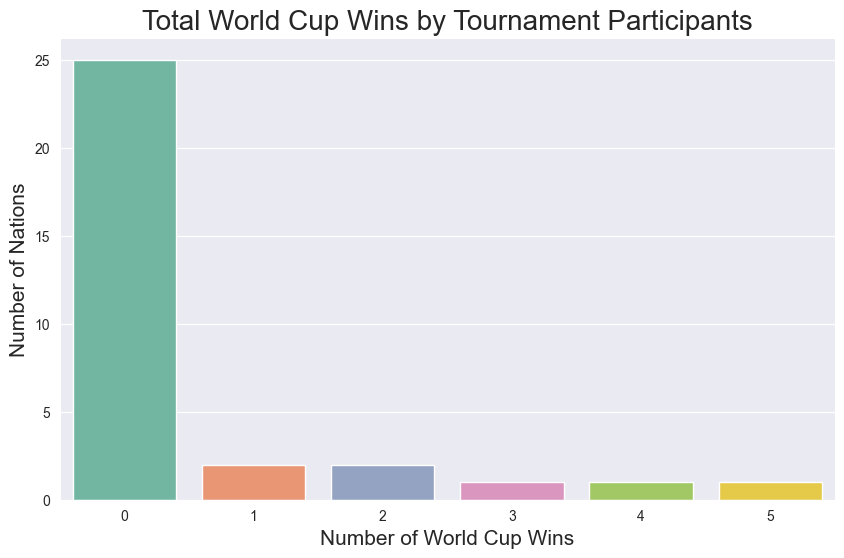

In [32]:
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

sns.countplot(x='World Cup Wins', data=countries, palette='Set2')
plt.title('Total World Cup Wins by Tournament Participants', fontsize=20)
plt.xlabel('Number of World Cup Wins', fontsize=15)
plt.ylabel('Number of Nations', fontsize=15)
plt.show()

It is easy here to see that most of the countries have never won a World Cup, and a few countries have won one, or two. There are three countries however that have won 3 or more, so let's see who they are.

In [33]:
countries[countries['World Cup Wins'] >= 3]['World Cup Wins'].to_frame().sort_values('World Cup Wins', ascending=False)

,World Cup Wins
Nation,
Brazil,5
Germany,4
Argentina,3


In [34]:
TOTAL_WORLD_CUPS = 22
TOTAL_WORLD_CUPS - countries['World Cup Wins'].sum()

4

This is notable because the total number of World Cups played is 22 (counting this one), and we have 18 of the winners represented here. That would mean that 4 World Cup winners did not qualify for this World Cup, which is a very interesting statistic. The other 4 missing World Cups were all won by Italy, who failed to qualify to this World Cup due to a surprise 1-0 upset loss in a World Cup qualifying match to North Macedonia.

## Visualizing the players, and their performances

#### Players: Background Analysis

We want to gain a better understanding of the actual participants in the tournament; who they are, how old they are, where they play on the pitch, and so on. We will be using the `players` dataset to help us with this background analysis.

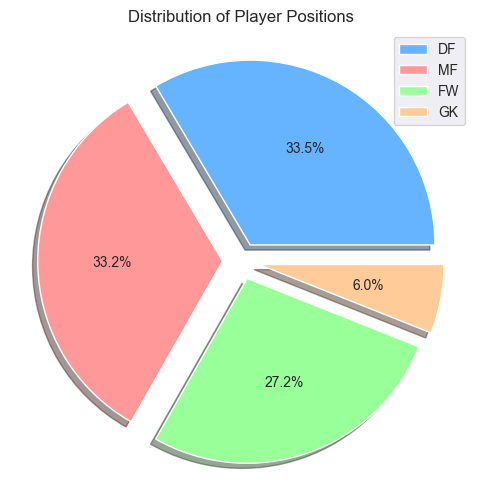

In [35]:
colors = ['#66b3ff','#ff9999','#99ff99','#ffcc99']

ax = plt.figure(figsize=(10, 6))

ax = players['position'].value_counts().plot(kind='pie', 
                                        autopct='%1.1f%%', shadow=True, explode=[0.1, 0.1, 0.1, 0.1], colors=colors, 
                                        legend=True, title='Distribution of Player Positions', ylabel='', labeldistance=None)

Here we can see a very similar distribution of defenders and midfielders, which makes sense because there are multiple defenders and midfielders in team compositions, and only one goalkeeper and usually one or two forwards. One can assume that this given makeup is consistent with the rest of each roster for every team in the tournament, and we can see that the majority of players in the tournament are defenders and midfielders.

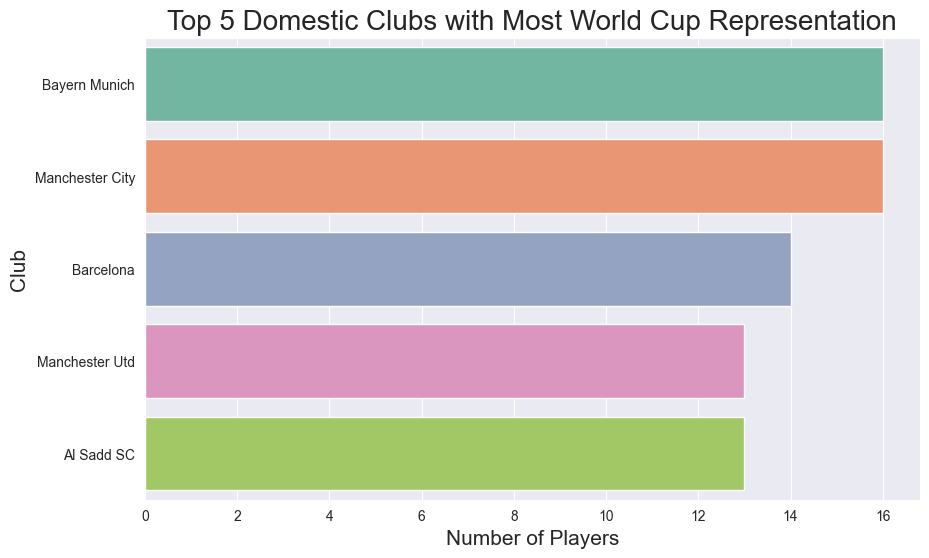

In [36]:
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.countplot(y='club', data=players, order=players['club'].value_counts().iloc[:5].index, palette='Set2')
plt.title('Top 5 Domestic Clubs with Most World Cup Representation', fontsize=20)
plt.xlabel('Number of Players', fontsize=15)
plt.ylabel('Club', fontsize=15)
plt.show()

Al Sadd SC is an interesting outlier because all of these other clubs are very well known and highly regarded around the world, but Al Sadd SC does not fit the mold of the rest of these historic clubs. The reason behind the strong showing from Al Saad SC is because it is a club in Qatar (who is the host nation of this World Cup), and the majority of the players from the Qatar national team actually play for that club.

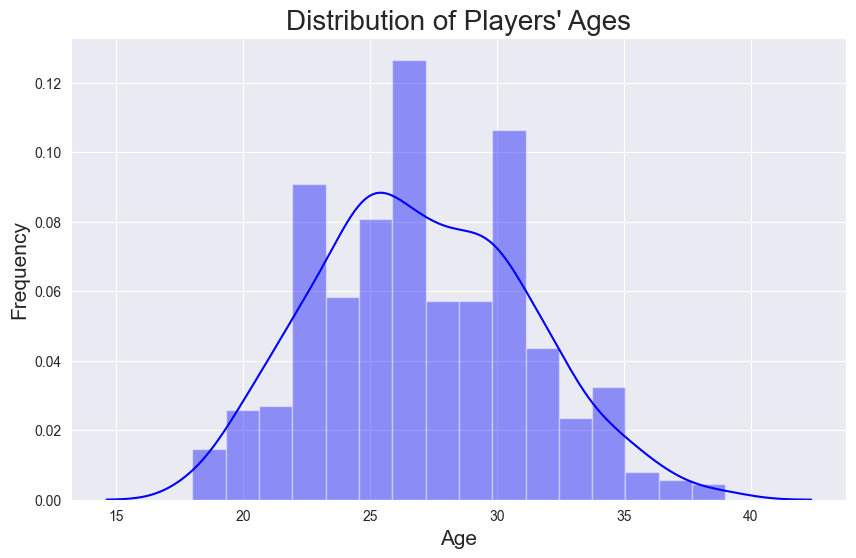

In [37]:
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

sns.distplot(players['age'], color='blue')
plt.title('Distribution of Players\' Ages', fontsize=20)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

In [38]:
players['age'].mean()

27.054411764705883

Based on the visual, and with our `.mean()` as further proof, we can see that there are a lot of players in the 27 y/o range, with other spikes at around the 30-32 range, and at the 21-23 range as well. This makes us interested, though, in who the oldest and youngest players were in the tournament.

In [39]:
players.sort_values('age', ascending=False).head()[['player', 'age', 'team', 'position', 'goals', 'assists']].sort_values('goals', ascending=False)

,player,age,team,position,goals,assists
519,Pepe,39,Portugal,DF,1,0
142,Dani Alves,39,Brazil,DF,0,0
75,Atiba Hutchinson,39,Canada,MF,0,0
616,Thiago Silva,38,Brazil,DF,0,1
108,Bryan Ruiz,37,Costa Rica,MF,0,0


In [40]:
players.sort_values('age').head()[['player', 'age', 'team', 'position', 'goals', 'assists']].sort_values('goals', ascending=False)

,player,age,team,position,goals,assists
217,Gavi,18,Spain,MF,1,0
215,Garang Kuol,18,Australia,FW,0,0
666,Youssoufa Moukoko,18,Germany,FW,0,0
94,Bilal El Khannous,18,Morocco,MF,0,0
7,Abdul Fatawu Issahaku,18,Ghana,FW,0,0


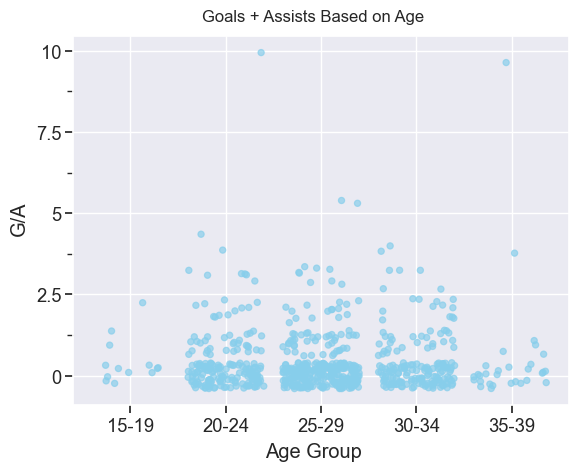

<ggplot: (690217777)>

In [88]:
players['Age Group'] = pd.cut(players['age'], range(15, 45, 5), right=False)
players['Age Group']
(ggplot(players, aes(x='Age Group', y='G/A'))
 + geom_point(color='skyblue', size=2, alpha=0.7, position='jitter')
 + labs(x='Age Group', y='G/A')
 + theme(legend_position='none', axis_text=element_text(size=12), axis_title=element_text(size=14))
 + ggtitle('Goals + Assists Based on Age')
+ scale_x_discrete(labels=['15-19', '20-24', '25-29', '30-34', '35-39'])
+ theme_seaborn(context='notebook', style='darkgrid', font='sans-serif', font_scale=1.2)
)

It was an interesting observation that there are no players in the tournament actually over the age of 40, and that there were no players under the age of 18.

### Observing advanced statistics to find the best offensive players

In doing research for this project, it has come to our attention that there are a certain selection of advanced statistics that are considered to be relevant in regard to offensive player performance. The dataset which we are working with *does* contain these statistics, so we are going to take a look at them, and see if we can find any interesting trends or insights. 

#### xG and xA

xG, or Expected Goals, is a metric that is used to measure the quality of a shot taken by a player. The higher the xG, the more likely the shot is to go in. xA, or Expected Assists, is a metric that is used to measure the quality of a pass that leads to a shot. The higher the xA, the more likely the pass is to lead to a goal. These are key metrics in modern football, and are frequently used to measure the quality of a player's performance. We will be exploring these metrics to determine which players are deemed most efficient in the tournament based on their criteria.

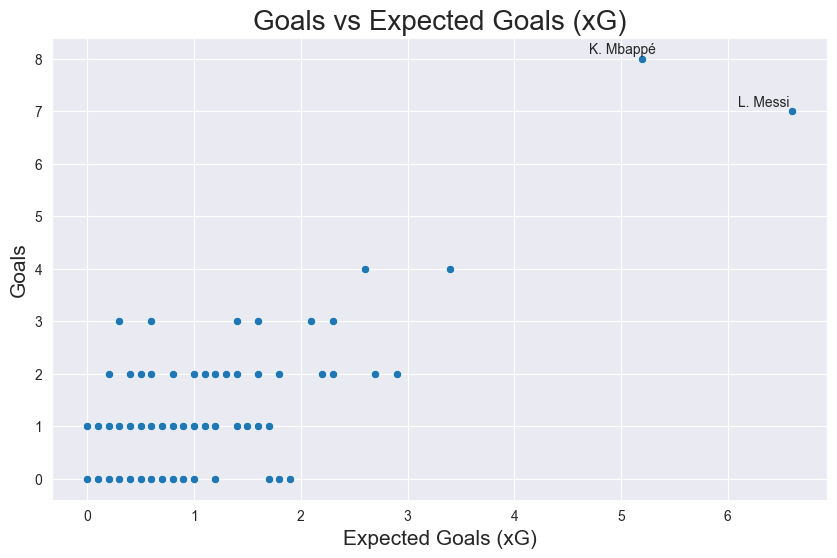

In [41]:
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

sns.scatterplot(x='xg', y='goals', data=players, palette='Set3')
plt.title('Goals vs Expected Goals (xG)', fontsize=20)
plt.xlabel('Expected Goals (xG)', fontsize=15)
plt.ylabel('Goals', fontsize=15)

# finding the outliers
outliers = players[players['goals'] > players['goals'].quantile(.97) + 1.5 * (players['goals'].quantile(.97) - players['goals'].quantile(.03))]


# adding labels to the outliers
for i, row in outliers.iterrows():
    playerName = row['player']
    try:
        formattedPlayerName = f'{playerName[0]}. {playerName.split(" ")[1]}'
    except:
        # they only go by one name: ex. Richarlison or Gavi
        formattedPlayerName = playerName
    plt.annotate(formattedPlayerName, xy=(row['xg'], row['goals']), xytext=(row['xg']-.5, row['goals']+.1))

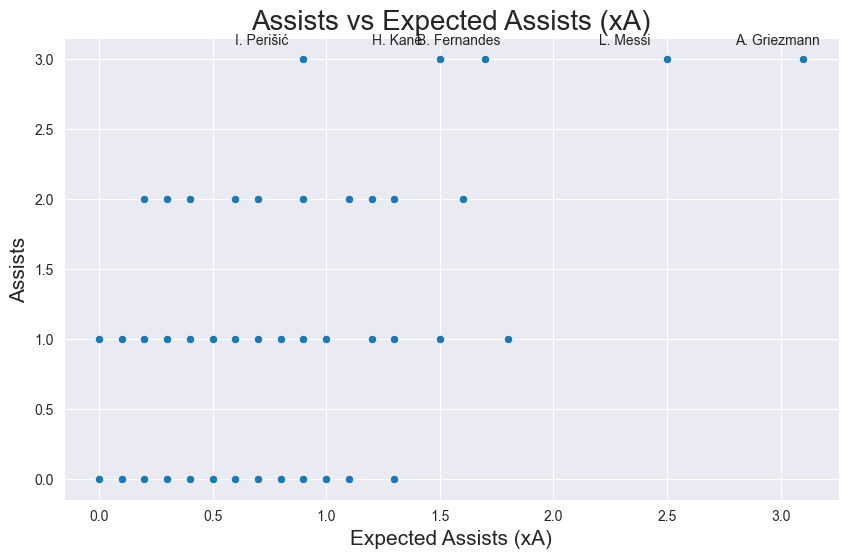

In [42]:
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

sns.scatterplot(x='xg_assist', y='assists', data=players, palette='Set3')
plt.title('Assists vs Expected Assists (xA)', fontsize=20)
plt.xlabel('Expected Assists (xA)', fontsize=15)
plt.ylabel('Assists', fontsize=15)

# Find the outliers
outliers = players[players['assists'] > players['assists'].quantile(.96) + 1.5 * (players['assists'].quantile(.96) - players['assists'].quantile(0.04))]


# Add labels to the outliers
for i, row in outliers.iterrows():
    playerName = row['player']
    try:
        formattedPlayerName = f'{playerName[0]}. {playerName.split(" ")[1]}'
    except:
        # they only go by one name: ex. Richarlison or Gavi
        formattedPlayerName = playerName
    plt.annotate(formattedPlayerName, xy=(row['xg_assist'], row['assists']), xytext=(row['xg_assist']-0.3, row['assists']+0.1))

#### G/A

G/A is a metric that is used to measure the total amount of goals and assists that a player has, by simply adding together the two. G/A per 90 is a metric that is used to measure the total amount of goals and assists that a player has per 90 minutes played. We will be exploring these metrics to determine which players are deemed most efficient in the tournament based on these criteria.

Text(0, 0.5, 'Player')

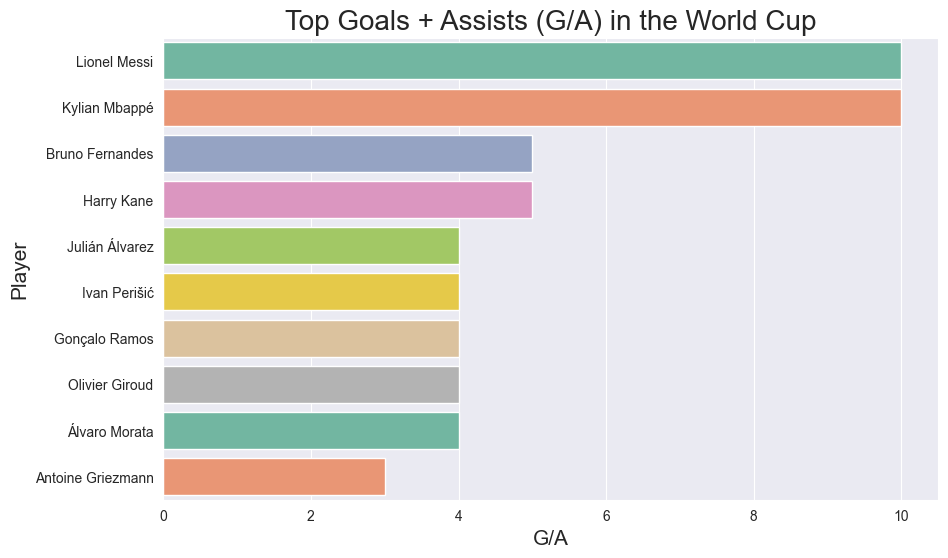

In [43]:
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

sns.barplot(x='G/A', y='player', data=players.sort_values('G/A', ascending=False).head(10), palette='Set2')
plt.title('Top Goals + Assists (G/A) in the World Cup', fontsize=20)
plt.xlabel('G/A', fontsize=15)
plt.ylabel('Player', fontsize=15)

Ultimately, an easy indicator of a player's performance is their goals + assists (G/A), and we can see that tied at the top, is none other than Lionel Messi and Kylian Mbappe, who both had a total of 10 G/A throughout the tournament. Again, it's important to note that both Messi and Mbappe played in every possible match in the tournament, which can serve as a reason why their G/A output is so high compared to others. This is why `G/A per 90` is a statistic that is used to measure the efficiency of a player, because it takes into account the amount of time that a player is on the pitch, and how much they are able to produce in that time.

#### SCA

SCA is an advanced statistic that is defined as a shot-creating action, which is a pass, dribble, or drawing of a foul that leads to a shot. This is an interesting statistic because it can show us who is creating the most chances for their team, and who is the most involved in the attack. SCA per 90 is a metric that is used to measure the total amount of shot-creating actions that a player has per 90 minutes played. We will be exploring these metrics to determine which players are deemed most efficient in the tournament based on these criteria.

Text(0, 0.5, 'Player')

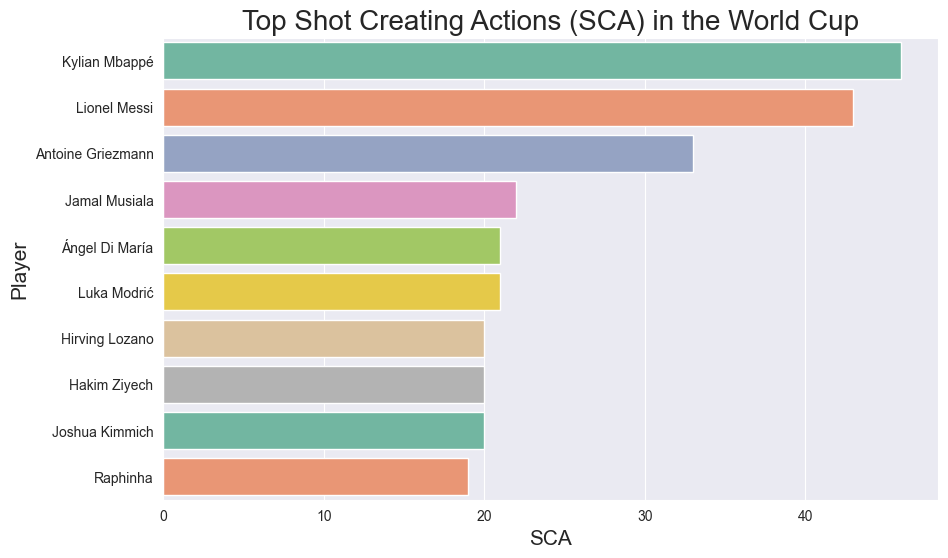

In [44]:
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

sns.barplot(x='sca', y='player', data=players.sort_values('sca', ascending=False).head(10), palette='Set2')
plt.title('Top Shot Creating Actions (SCA) in the World Cup', fontsize=20)
plt.xlabel('SCA', fontsize=15)
plt.ylabel('Player', fontsize=15)

SCA is an advanced statistic that is defined as a shot-creating action, which is a pass, dribble, or drawing of a foul that leads to a shot. This is an interesting statistic because it can show us who is creating the most chances for their team, and who is the most involved in the attack. Here, we are seeing many new names, like Rodrygo and Gabriel Martinelli of Brazil, as well as some familar names like Lionel Messi and Kylian Mbappe.

#### Putting it all together

Ultimately, we are curious how SCA actually coorelates with G/A, so we are going to visualize that relationship. In other words; our leaders in SCA, are they also our leaders in G/A?

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Kylian Mbappé'),
  Text(1, 0, 'Lionel Messi'),
  Text(2, 0, 'Antoine Griezmann'),
  Text(3, 0, 'Jamal Musiala'),
  Text(4, 0, 'Ángel Di María'),
  Text(5, 0, 'Luka Modrić'),
  Text(6, 0, 'Hirving Lozano'),
  Text(7, 0, 'Hakim Ziyech'),
  Text(8, 0, 'Joshua Kimmich'),
  Text(9, 0, 'Raphinha')])

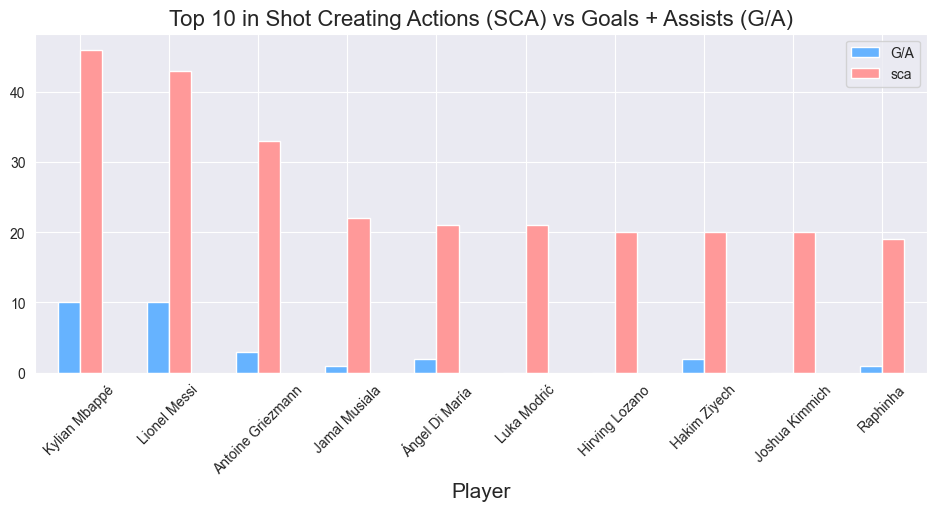

In [45]:
_top_sca = players.sort_values('sca', ascending=False).head(10)
top_sca = _top_sca[['player', 'G/A', 'sca']]
top_sca = top_sca.set_index('player')


sns.set_style('darkgrid')
top_sca.plot.bar(figsize=(10, 6), color=['#66b3ff','#ff9999'])

plt.title('Top 10 in Shot Creating Actions (SCA) vs Goals + Assists (G/A)', fontsize=16)
plt.xlabel('Player', fontsize=15)

plt.tight_layout(pad=3.0)
plt.xticks(rotation=45)

In total, there *does* seem to be a coorelation between SCA and G/A, but it is not necessarily a very strong one. While we do see some of the same names, like Mbappe, Messi, and the king of advanced assist statistics in Antoine Griezmann, we also see some new names, like Luka Modric, Hirving Lozano, and Joshua Kimmich, who have 0 G/A combined. This is an interesting observation, because it shows that while SCA is a good indicator of goal scoring opportunities (which in turn leads to goals and/or assists), it is not necessarily a strong indicator of G/A. However, it is still a good indicator of who is creating the most chances for their team, and who is the most involved in the attack.

## Visualizing the rounds of the tournament

There is an infinite amount of categories that can be observed, and a long list of interesting trends, features, statistics, and more than can be analyzed for each match, and for each round. Our research question in specifics to each round is: *As the rounds go on, do teams tend to play more conservatively, or do they play more aggressively?* To answer this question, there are a few things we want to look at generally for each round as a whole. It should be noted that if there is an interest at observing a specific match, I have created a tool that allows you to select a match, and observe the statistics for that match. You can find that tool [here](https://ccvale-2022-qatar-world-cup-analysis-guiapp-go6eoz.streamlit.app/).

The features we will be comparing for each round are:

- Total goals scored in each match of the round

- Total number of passes in each match of the round

- Total amount of fouls in each match of the round


### Does the difference in rounds have an effect on the way that teams play?

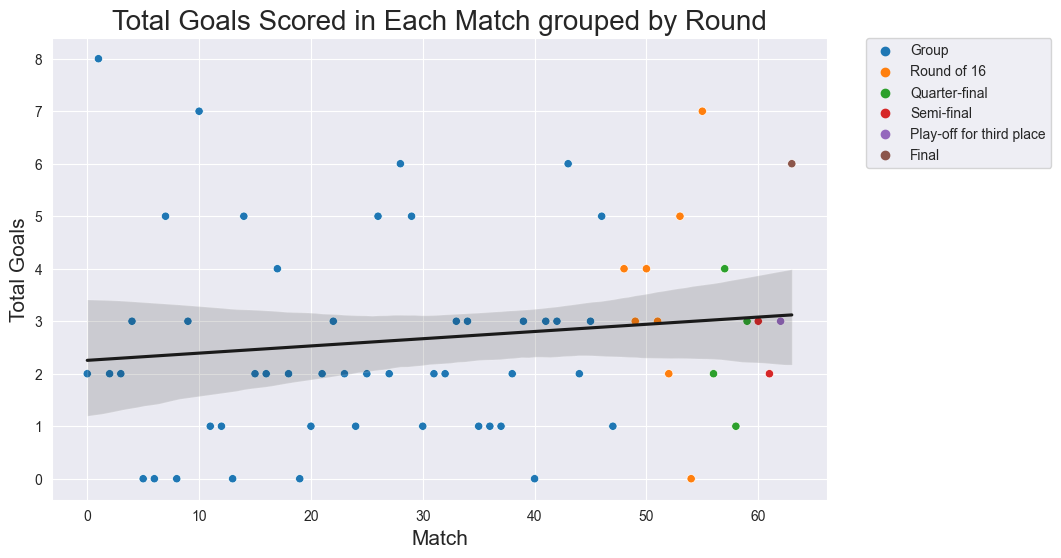

In [47]:
matches['total_goals'] = matches['number of goals team1'] + matches['number of goals team2']

plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.scatterplot(data=matches, x=matches.index, y='total_goals', hue='category')
sns.regplot(x=matches.index, y='total_goals', data=matches, scatter=False, color=".1")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Total Goals Scored in Each Match grouped by Round', fontsize=20)
plt.xlabel('Match', fontsize=15)
plt.ylabel('Total Goals', fontsize=15)
plt.show()

We can see that most matches resulted in a game with a little under 3 or less goals per game, but 11 of the 16 knockout matches also resulted in 3 or more goals scored, which shows us that knockout matches were more likely to perform above the mean in terms of goals scored. This is an interesting observation, because it shows that teams might be more likely to play more aggressively in knockout matches, which makes sense because there is more at stake in a knockout match than in a group stage match.

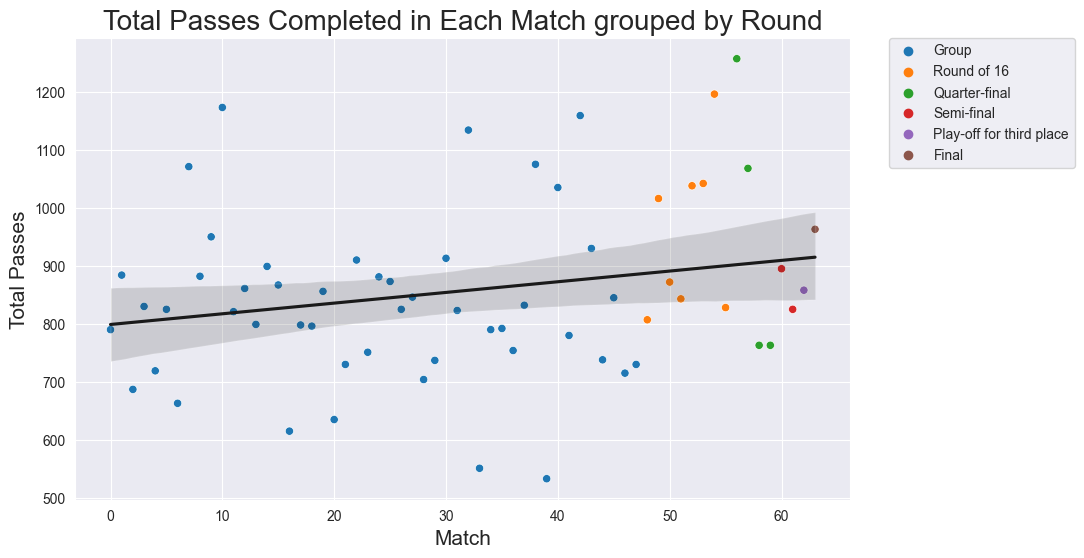

In [48]:
matches['total_passes'] = matches['passes completed team1'] + matches['passes completed team2']

plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.scatterplot(data=matches, x=matches.index, y='total_passes', hue='category')
sns.regplot(x=matches.index, y='total_passes', data=matches, scatter=False, color=".1")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Total Passes Completed in Each Match grouped by Round', fontsize=20)
plt.xlabel('Match', fontsize=15)
plt.ylabel('Total Passes', fontsize=15)
plt.show()

A trend we're able to see here is that a majority of matches throughout the tournament end up with around 800-900 total passes completed by both teams combined. It is interesting to note that outside of 900 passes, it seems to be an even split between group play matches and elimination matches.

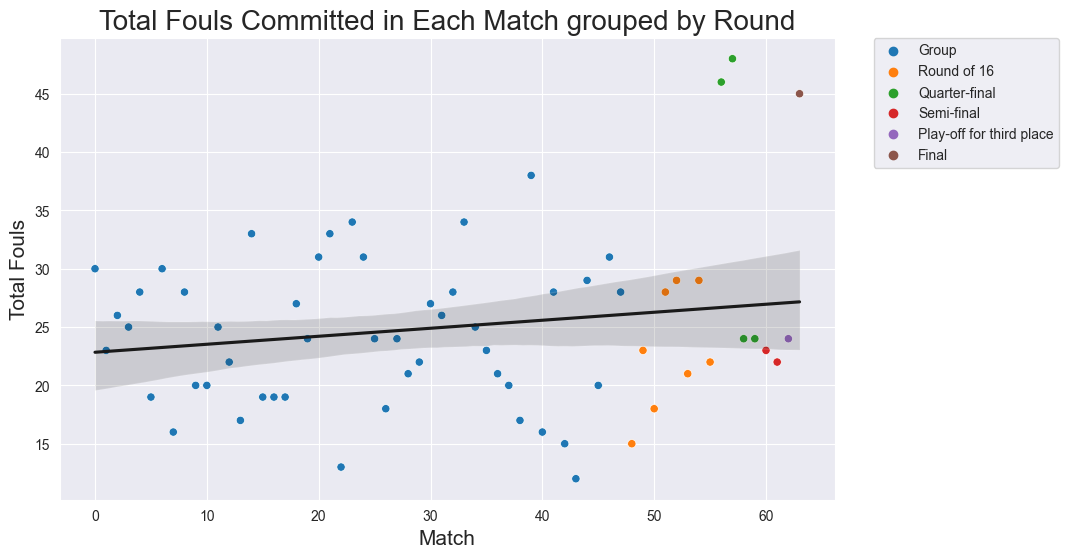

In [49]:
matches['total_fouls'] = matches['fouls against team1'] + matches['fouls against team2']

plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.scatterplot(data=matches, x=matches.index, y='total_fouls', hue='category')
sns.regplot(x=matches.index, y='total_fouls', data=matches, scatter=False, color=".1")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Total Fouls Committed in Each Match grouped by Round', fontsize=20)
plt.xlabel('Match', fontsize=15)
plt.ylabel('Total Fouls', fontsize=15)
plt.show()

We are actually observing a tendancy for less fouls than the mean to occur in knockout matches, with the exception of two quarter final matches, and the final, which were all outliers in the sense that 45+ fouls were committed in all three of these matches, which is a lot more than the mean of around 24.

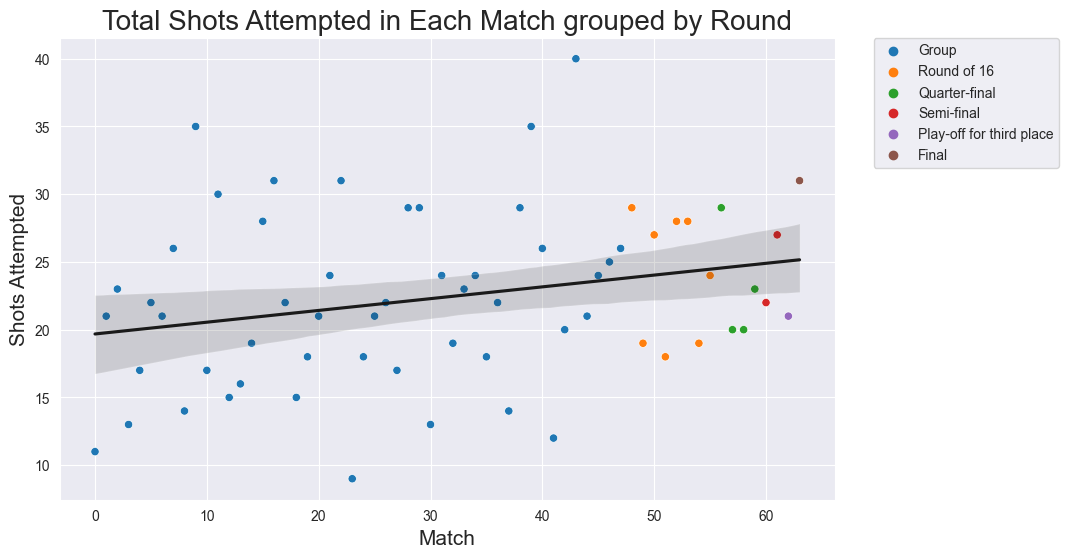

In [50]:
matches['total_shot_attempts'] = matches['total attempts team1'] + matches['total attempts team2']

plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.scatterplot(data=matches, x=matches.index, y='total_shot_attempts', hue='category')
sns.regplot(x=matches.index, y='total_shot_attempts', data=matches, scatter=False, color='.1')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Total Shots Attempted in Each Match grouped by Round', fontsize=20)
plt.xlabel('Match', fontsize=15)
plt.ylabel('Shots Attempted', fontsize=15)
plt.show()
# different kind of plot??

To conclude, by looking at all of these statistics, we don't particularly see a substantial change in the way teams are playing in knockout matches compared to group stage matches. However, we do see a slight increase in goals scored, and a slight decrease in fouls committed, which could be an indicator that teams are adjusting their play in knockout matches, but it is not a strong enough indicator to make a definitive conclusion.

### Does having more possession actually lead to more success?

In [51]:
matches['possession win'] = ''
possession_wins = 0
possession_losses = 0
possession_draws = 0
for i, row in matches.iterrows():
    if row['number of goals team1'] != row['number of goals team2']:
        if (row['possession team1'] > row['possession team2'] and row['number of goals team1'] > row['number of goals team2']) or (row['possession team2'] > row['possession team1'] and row['number of goals team2'] > row['number of goals team1']):
            matches.at[i, 'possession win'] = 'Win'
            possession_wins += 1
        else:
            possession_losses += 1
            matches.at[i, 'possession win'] = 'Loss'
    else:
        matches.at[i, 'possession win'] = 'Draw'
        possession_draws += 1

print(f'Teams with more possession won {possession_wins} games, drew {possession_draws} games, and lost {possession_losses} games.')

Teams with more possession won 22 games, drew 15 games, and lost 27 games.


<Figure size 1000x600 with 0 Axes>

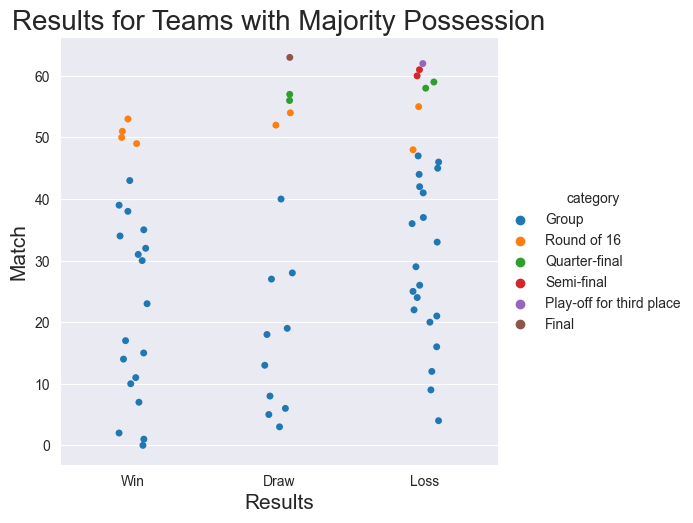

In [52]:
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.catplot(data=matches, y=matches.index, x='possession win', hue='category')

plt.title('Results for Teams with Majority Possession', fontsize=20)
plt.xlabel('Results', fontsize=15)
plt.ylabel('Match', fontsize=15)
plt.show()

We can see that broken down by round:

- More teams lost with majority possession in group play

- The round of 16 was very close, and the distribution of wins was very even

- A similar trend can be seen in the quarterfinals, but it can be noted that no team with majority possession won in the quarterfinals

- No team in the semifinals won with possession

- The final resulted in a draw after extra time, and went to penalty kicks

- The third place match resulted in a loss for the team that held majority possession

So, we can see that possession is not a very good indicator of success in the World Cup, and that it is not a very good indicator of success in the later rounds of the tournament. This is interesting because it is a common belief that the team that holds majority possession is the team that is more likely to win the match, and that in high pressure tournament situations, there is room for many different strategies to win. For example, in the knockout match between the United States and the Netherlands, although the United States had majority of possession, the Netherlands played to their tactics and were in complete control of the game, as they were able to win 3-1. This is a good example of how possession is not a good indicator of success, and how teams can play to their strengths and win matches.

### Which matches were the most/least attended; is there a trend we can notice?

In [53]:
print(f'The average attendance for all matches in the tournament is: {round(matches["attendance"].mean(),2)} people per match.')

The average attendance for all matches in the tournament is: 53191.44 people per match.


In [54]:
# visualize the top 5 matches with attendance
top_5_attendance = matches.sort_values('attendance', ascending=False).head(5)
top_5_attendance[['team1', 'team2', 'category', 'attendance', 'venue']]

,team1,team2,category,attendance,venue
63,Argentina,France,Final,88966,Lusail Iconic Stadium
60,Argentina,Croatia,Semi-final,88966,Lusail Iconic Stadium
23,Argentina,Mexico,Group,88966,Lusail Iconic Stadium
31,Portugal,Uruguay,Group,88668,Lusail Iconic Stadium
57,Netherlands,Argentina,Quarter-final,88235,Lusail Iconic Stadium


In [55]:
# visualize the top 5 matches with attendance
bottom5 = matches.sort_values('attendance', ascending=True).head(5)
bottom5[['team1', 'team2', 'category', 'attendance', 'venue']]

,team1,team2,category,attendance,venue
12,Switzerland,Cameroon,Group,39089,Al Janoub Stadium
6,Mexico,Poland,Group,39369,Stadium 974
28,Cameroon,Serbia,Group,39789,Al Janoub Stadium
10,Spain,Costa Rica,Group,40013,Al Thumama Stadium
11,Belgium,Canada,Group,40432,Ahmed bin Ali Stadium


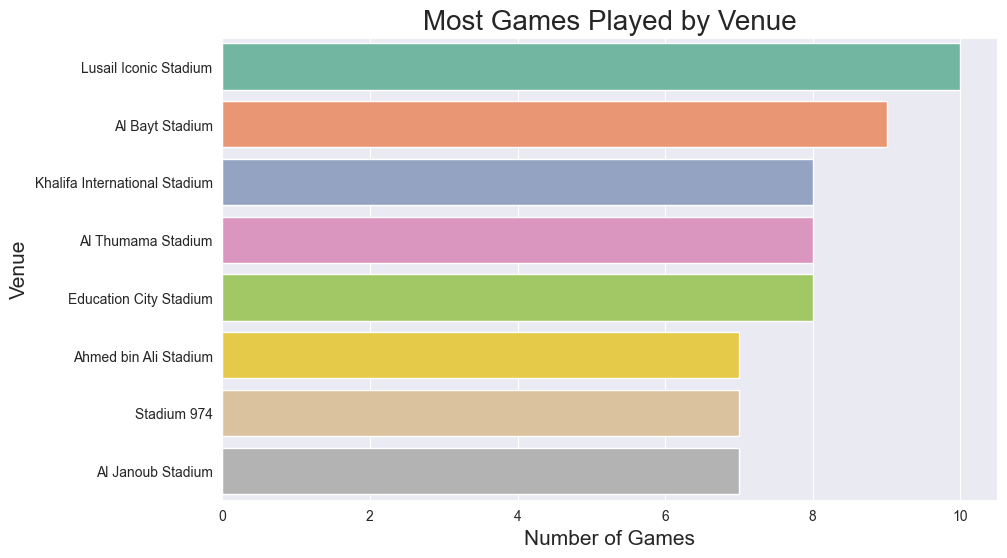

In [56]:
# create a graph to visualize the most games played by venue
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.countplot(y='venue', data=matches, order=matches['venue'].value_counts().index, palette='Set2')

plt.title('Most Games Played by Venue', fontsize=20)
plt.xlabel('Number of Games', fontsize=15)
plt.ylabel('Venue', fontsize=15)
plt.show()


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Al Bayt Stadium'),
  Text(1, 0, 'Khalifa International Stadium'),
  Text(2, 0, 'Al Thumama Stadium'),
  Text(3, 0, 'Ahmed bin Ali Stadium'),
  Text(4, 0, 'Lusail Iconic Stadium'),
  Text(5, 0, 'Education City Stadium'),
  Text(6, 0, 'Stadium 974'),
  Text(7, 0, 'Al Janoub Stadium')])

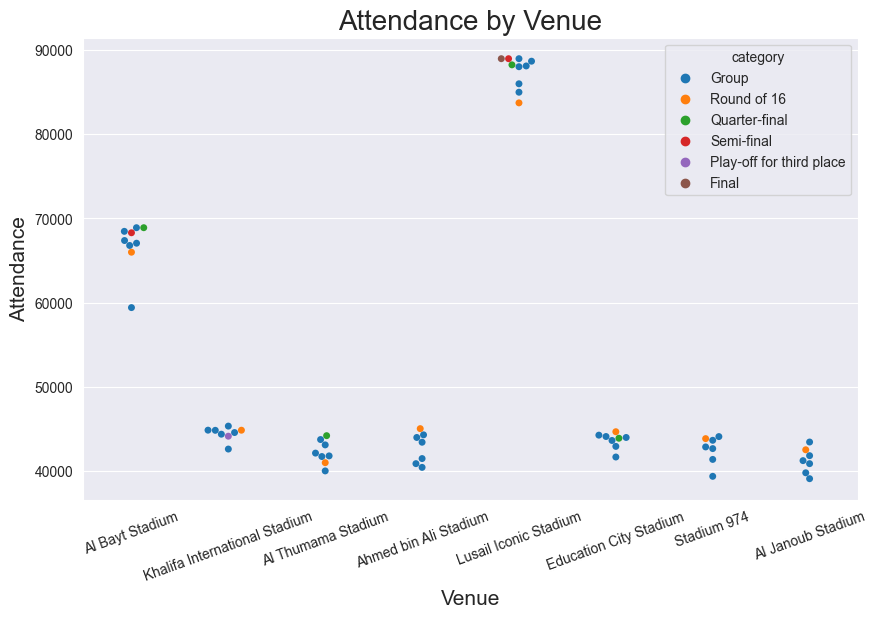

In [57]:
# plot venue vs attendance
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.swarmplot(data=matches, x='venue', y='attendance', hue='category')
# title and labels
plt.title('Attendance by Venue', fontsize=20)
plt.xlabel('Venue', fontsize=15)
plt.ylabel('Attendance', fontsize=15)
plt.xticks(rotation=20)

Interesting things to note here is that all of the most attended matches were at Lusail Iconic Stadium, and 4 out of the top 5 matches had Argentina playing. So while we can see that Argentina is a very popular team, we can also see that the Lusail Iconic Stadium is a very big stadium, which has also hosted the most matches in the tournament. So, it is not surprising that the most attended matches were at this stadium if you keep that in mind, and consider that two of the most attended matches at this stadium were the World Cup Final, and Argentina's semifinal match against Croatia.

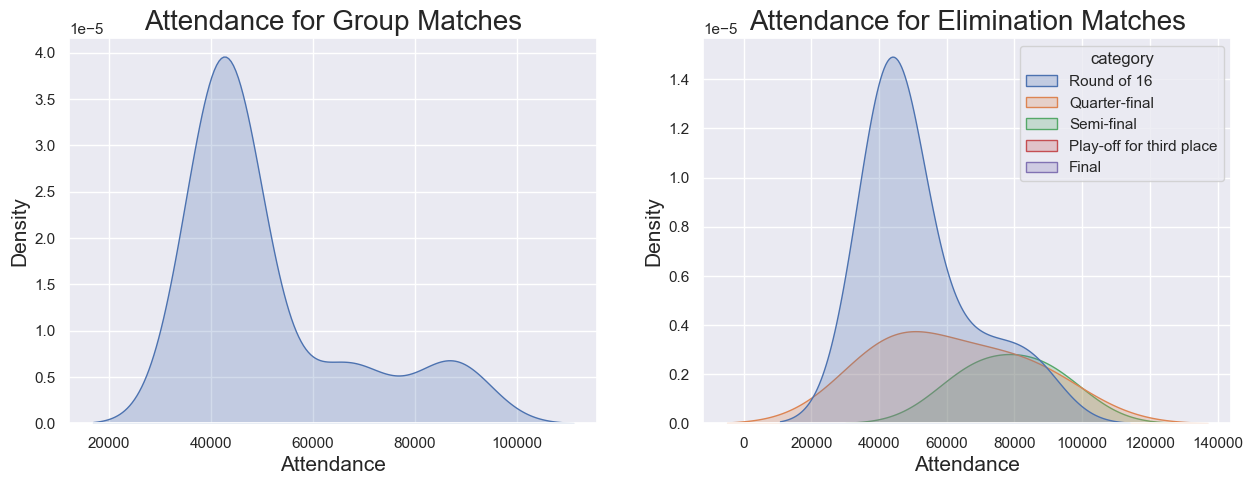

In [95]:
# create two density plots side by side; one for attendance when category is Group, and one for attendance when category is everything else
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style('darkgrid')
sns.kdeplot(data=matches[matches['category'] == 'Group'], x='attendance', shade=True, ax=axes[0])
sns.kdeplot(data=matches[matches['category'] != 'Group'], x='attendance', hue='category',label='Other', shade=True, ax=axes[1])

axes[0].set_title('Attendance for Group Matches', fontsize=20)
axes[0].set_xlabel('Attendance', fontsize=15)
axes[0].set_ylabel('Density', fontsize=15)
axes[1].set_title('Attendance for Elimination Matches', fontsize=20)
axes[1].set_xlabel('Attendance', fontsize=15)
axes[1].set_ylabel('Density', fontsize=15)
plt.show()

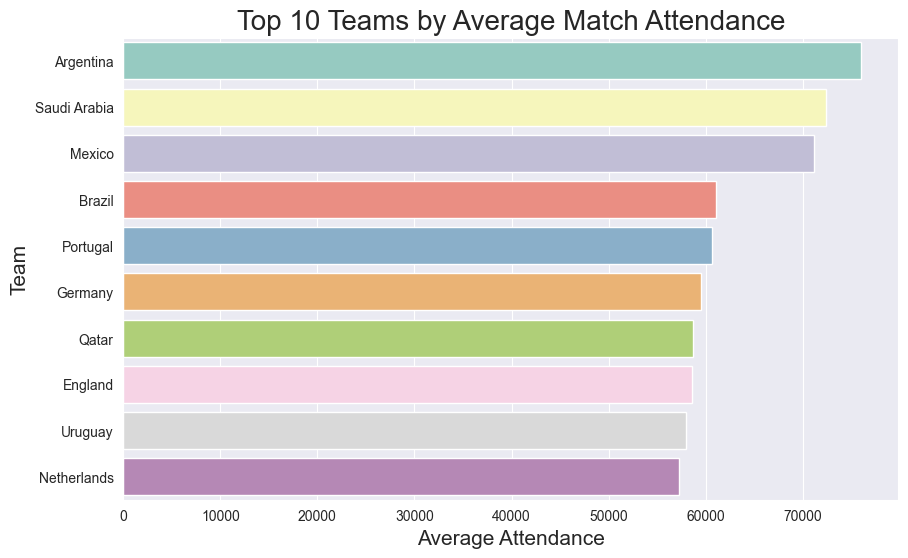

In [59]:
team_attendance = matches.groupby('team1')['attendance'].sum() + matches.groupby('team2')['attendance'].sum()
team_matches = matches.groupby('team1')['attendance'].count() + matches.groupby('team2')['attendance'].count()
team_attendance = (team_attendance / team_matches).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.barplot(x=team_attendance.head(10), y=team_attendance.head(10).index, palette='Set3')

plt.title('Top 10 Teams by Average Match Attendance', fontsize=20)
plt.xlabel('Average Attendance', fontsize=15)
plt.ylabel('Team', fontsize=15)
plt.show()